# Amazon Web Services - Use Case 1 : Default of credit card clients

## Using XGBoost on SageMaker

In this notebook, we build, train to predict the target label Y Did the person pay default payment next month field (Yes=1 or No=0 ). 

1. <a href="#1">Read the dataset</a>
2. <a href="#2">Exploratory Data Analysis</a>
3. <a href="#3">Select features to build the model</a>
4. <a href="#6">Train the classifier</a>


## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's read the dataset into a dataframe, using Pandas.

In [1]:
import pandas as pd
import numpy as np                                
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image                 
from IPython.display import display               
from sklearn.datasets import dump_svmlight_file   
from time import gmtime, strftime                 
import sys                                        
import math                                       
import json
import boto3
import sagemaker

import warnings
warnings.filterwarnings("ignore")
# to prevent truncating the columns of the pandas dataframe
pd.set_option('display.max_columns', None)

bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/fifa19'
role = sagemaker.get_execution_role()

print('Bucket:\n{}'.format(bucket))


Bucket:
sagemaker-us-east-1-168402291854


In [2]:
df = pd.read_excel('default of credit card clients.xls', index_col=0, header=[0, 1])

In [3]:
df.head()

X1      X2          X3       X4  X5    X6    X7    X8    X9   X10  \
ID LIMIT_BAL     SEX   EDUCATION MARRIAGE AGE PAY_0 PAY_2 PAY_3 PAY_4 PAY_5   
1      20000  female  university  married  24     2     2    -1    -1    -2   
2     120000  female  university   single  26    -1     2     0     0     0   
3      90000  female  university   single  34     0     0     0     0     0   
4      50000  female  university  married  37     0     0     0     0     0   
5      50000    male  university  married  57    -1     0    -1     0     0   

     X11       X12       X13       X14       X15       X16       X17      X18  \
ID PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 BILL_AMT6 PAY_AMT1   
1     -2      3913      3102       689         0         0         0        0   
2      2      2682      1725      2682      3272      3455      3261        0   
3      0     29239     14027     13559     14331     14948     15549     1518   
4      0     46990     48233     49291     28314     28959     29547     2000   
5      0      8617      5670     35835     20940     19146     19131     2000   

        X19      X20      X21      X22      X23                          Y  
ID PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5 PAY_AMT6 default payment next month  
1       689        0        0        0        0                          1  
2      1000     1000     1000        0     2000                          1  
3      1500     1000     1000     1000     5000                          0  
4      2019     1200     1100     1069     1000                          0  
5     36681    10000     9000      689      679                          0

## 2. <a name="2">Exploratory Data Analysis</a>
(<a href="#0">Go to top</a>)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   (X1, LIMIT_BAL)                  30000 non-null  int64 
 1   (X2, SEX)                        30000 non-null  object
 2   (X3, EDUCATION)                  29669 non-null  object
 3   (X4, MARRIAGE)                   29677 non-null  object
 4   (X5, AGE)                        30000 non-null  int64 
 5   (X6, PAY_0)                      30000 non-null  int64 
 6   (X7, PAY_2)                      30000 non-null  int64 
 7   (X8, PAY_3)                      30000 non-null  int64 
 8   (X9, PAY_4)                      30000 non-null  int64 
 9   (X10, PAY_5)                     30000 non-null  int64 
 10  (X11, PAY_6)                     30000 non-null  int64 
 11  (X12, BILL_AMT1)                 30000 non-null  int64 
 12  (X13, BILL_AMT2)                

Let's modify some of the data type

In [5]:
for col in ['X1','X12','X13','X14','X15','X16','X17','X18','X19','X20','X21','X22','X23']:
    df[col] = df[col].astype('float64')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   (X1, LIMIT_BAL)                  30000 non-null  float64
 1   (X2, SEX)                        30000 non-null  object 
 2   (X3, EDUCATION)                  29669 non-null  object 
 3   (X4, MARRIAGE)                   29677 non-null  object 
 4   (X5, AGE)                        30000 non-null  int64  
 5   (X6, PAY_0)                      30000 non-null  int64  
 6   (X7, PAY_2)                      30000 non-null  int64  
 7   (X8, PAY_3)                      30000 non-null  int64  
 8   (X9, PAY_4)                      30000 non-null  int64  
 9   (X10, PAY_5)                     30000 non-null  int64  
 10  (X11, PAY_6)                     30000 non-null  int64  
 11  (X12, BILL_AMT1)                 30000 non-null  float64
 12  (X13, BILL_AMT2)  

In [7]:
# print basic statistics for numerical columns
df.describe()

X1            X5            X6            X7            X8  \
ID          LIMIT_BAL           AGE         PAY_0         PAY_2         PAY_3   
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667     35.518833     -0.016700     -0.133767     -0.166200   
std     129747.661567      9.528019      1.123802      1.197186      1.196868   
min      10000.000000     21.000000     -2.000000     -2.000000     -2.000000   
25%      50000.000000     28.000000     -1.000000     -1.000000     -1.000000   
50%     140000.000000     34.000000      0.000000      0.000000      0.000000   
75%     240000.000000     41.000000      0.000000      0.000000      0.000000   
max    1000000.000000    267.000000      8.000000      8.000000      8.000000   

                 X9           X10           X11            X12            X13  \
ID            PAY_4         PAY_5         PAY_6      BILL_AMT1      BILL_AMT2   
count  30000.000000  30000.000000  30000.000000   30000.000000   30000.000000   
mean      -0.220667     -0.266200     -0.291100   51223.330900   49179.075167   
std        1.169139      1.133187      1.149988   73635.860576   71173.768783   
min       -2.000000     -2.000000     -2.000000 -165580.000000  -69777.000000   
25%       -1.000000     -1.000000     -1.000000    3558.750000    2984.750000   
50%        0.000000      0.000000      0.000000   22381.500000   21200.000000   
75%        0.000000      0.000000      0.000000   67091.000000   64006.250000   
max        8.000000      8.000000      8.000000  964511.000000  983931.000000   

                X14            X15            X16            X17  \
ID        BILL_AMT3      BILL_AMT4      BILL_AMT5      BILL_AMT6   
count  3.000000e+04   30000.000000   30000.000000   30000.000000   
mean   4.701315e+04   43262.948967   40311.400967   38871.760400   
std    6.934939e+04   64332.856134   60797.155770   59554.107537   
min   -1.572640e+05 -170000.000000  -81334.000000 -339603.000000   
25%    2.666250e+03    2326.750000    1763.000000    1256.000000   
50%    2.008850e+04   19052.000000   18104.500000   17071.000000   
75%    6.016475e+04   54506.000000   50190.500000   49198.250000   
max    1.664089e+06  891586.000000  927171.000000  961664.000000   

                 X18           X19           X20            X21  \
ID          PAY_AMT1      PAY_AMT2      PAY_AMT3       PAY_AMT4   
count   30000.000000  3.000000e+04   30000.00000   30000.000000   
mean     5663.580500  5.921163e+03    5225.68150    4826.076867   
std     16563.280354  2.304087e+04   17606.96147   15666.159744   
min         0.000000  0.000000e+00       0.00000       0.000000   
25%      1000.000000  8.330000e+02     390.00000     296.000000   
50%      2100.000000  2.009000e+03    1800.00000    1500.000000   
75%      5006.000000  5.000000e+03    4505.00000    4013.250000   
max    873552.000000  1.684259e+06  896040.00000  621000.000000   

                 X22            X23                          Y  
ID          PAY_AMT5       PAY_AMT6 default payment next month  
count   30000.000000   30000.000000               30000.000000  
mean     4799.387633    5215.502567                   0.221200  
std     15278.305679   17777.465775                   0.415062  
min         0.000000       0.000000                   0.000000  
25%       252.500000     117.750000                   0.000000  
50%      1500.000000    1500.000000                   0.000000  
75%      4031.500000    4000.000000                   0.000000  
max    426529.000000  528666.000000                   1.000000

Let's visualize the dataset to have overall overview

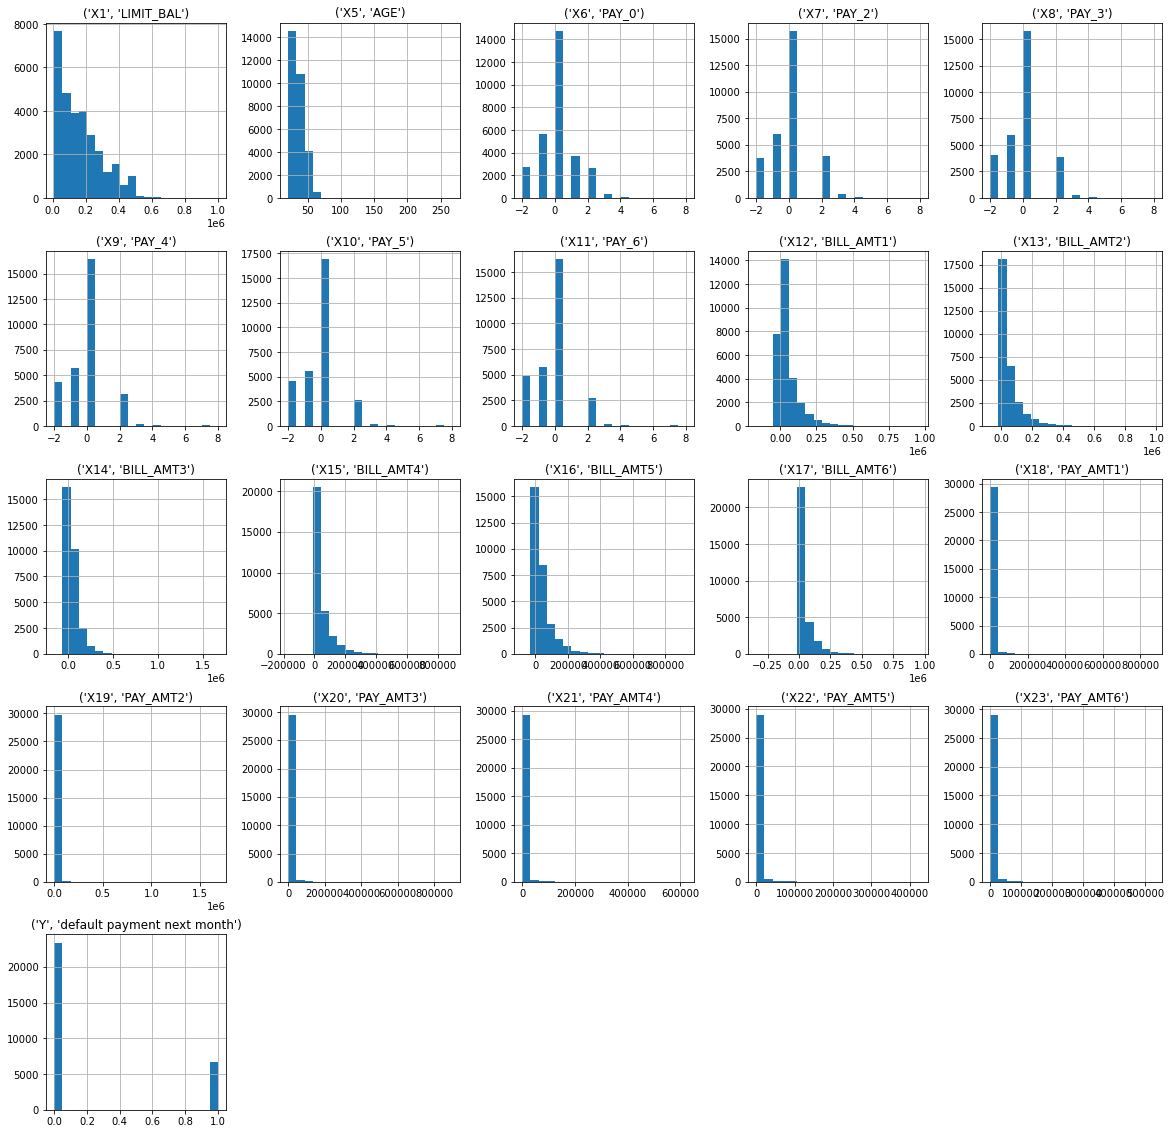

In [8]:
df.hist(figsize=(20,20), bins=20);

In [9]:
df['X5'].value_counts().sort_values()

AGE
267       1
228       1
140       1
152       1
74        1
       ... 
26     1255
30     1395
28     1408
27     1477
29     1605
Length: 63, dtype: int64

It's obvious that we have outliers in age column at 267, 228, 235, 140, 149, 152 and 126, Let's modify these values, here I removed the two hundreds and one hundred value cause I think it has been added by mistak   

In [10]:
df['X5'] = df['X5'].replace([267,228,235,140,149,152,126],[67,28,35,40,49,52,26])

In [11]:
df['X5'].value_counts().sort_values()

AGE
79        1
74        1
75        3
72        3
71        3
73        4
68        5
70       10
69       15
67       16
65       24
66       25
64       31
63       31
62       44
61       56
60       67
21       67
59       83
57      122
58      122
56      178
55      209
54      247
52      304
53      325
51      340
50      411
49      452
48      466
47      501
22      560
46      570
45      617
43      670
44      700
42      794
41      824
40      870
23      931
38      944
39      954
37     1041
36     1108
35     1113
24     1127
33     1146
32     1158
34     1162
25     1186
31     1217
26     1256
30     1395
28     1409
27     1477
29     1605
dtype: int64

In [12]:
df.isna().sum()

     ID                        
X1   LIMIT_BAL                       0
X2   SEX                             0
X3   EDUCATION                     331
X4   MARRIAGE                      323
X5   AGE                             0
X6   PAY_0                           0
X7   PAY_2                           0
X8   PAY_3                           0
X9   PAY_4                           0
X10  PAY_5                           0
X11  PAY_6                           0
X12  BILL_AMT1                       0
X13  BILL_AMT2                       0
X14  BILL_AMT3                       0
X15  BILL_AMT4                       0
X16  BILL_AMT5                       0
X17  BILL_AMT6                       0
X18  PAY_AMT1                        0
X19  PAY_AMT2                        0
X20  PAY_AMT3                        0
X21  PAY_AMT4                        0
X22  PAY_AMT5                        0
X23  PAY_AMT6                        0
Y    default payment next month      0
dtype: int64

In [13]:
df['X3'].value_counts()

EDUCATION      
university         14030
graduate school    10585
high school         4916
others               124
0                     14
dtype: int64

In [14]:
df['X4'].value_counts()

MARRIAGE
single      15964
married     13659
0              54
dtype: int64

Let's fill the missing values with the most frequent in EDUCATION and MARRIAGE

In [15]:
df['X3'] = df['X3'].fillna(df['X3'].mode().iloc[0])

In [16]:
df['X4'] = df['X4'].fillna(df['X4'].mode().iloc[0])

In [17]:
df.isna().sum()

     ID                        
X1   LIMIT_BAL                     0
X2   SEX                           0
X3   EDUCATION                     0
X4   MARRIAGE                      0
X5   AGE                           0
X6   PAY_0                         0
X7   PAY_2                         0
X8   PAY_3                         0
X9   PAY_4                         0
X10  PAY_5                         0
X11  PAY_6                         0
X12  BILL_AMT1                     0
X13  BILL_AMT2                     0
X14  BILL_AMT3                     0
X15  BILL_AMT4                     0
X16  BILL_AMT5                     0
X17  BILL_AMT6                     0
X18  PAY_AMT1                      0
X19  PAY_AMT2                      0
X20  PAY_AMT3                      0
X21  PAY_AMT4                      0
X22  PAY_AMT5                      0
X23  PAY_AMT6                      0
Y    default payment next month    0
dtype: int64

I have noticed that EDUCATION and MARRIAGE have a labels 0 that is undocumented, let's replace it with others.

In [18]:
df['X3'] = df['X3'].replace(0,'others')

In [19]:
df['X3'].value_counts()

EDUCATION      
university         14361
graduate school    10585
high school         4916
others               138
dtype: int64

In [20]:
df['X4'] = df['X4'].replace(0,'others')

In [21]:
df['X4'].value_counts()

MARRIAGE
single      16287
married     13659
others         54
dtype: int64

In [22]:
# Number of unique elements in dataset
df.nunique()

     ID                        
X1   LIMIT_BAL                        81
X2   SEX                               2
X3   EDUCATION                         4
X4   MARRIAGE                          3
X5   AGE                              56
X6   PAY_0                            11
X7   PAY_2                            11
X8   PAY_3                            11
X9   PAY_4                            11
X10  PAY_5                            10
X11  PAY_6                            10
X12  BILL_AMT1                     22723
X13  BILL_AMT2                     22346
X14  BILL_AMT3                     22026
X15  BILL_AMT4                     21548
X16  BILL_AMT5                     21010
X17  BILL_AMT6                     20604
X18  PAY_AMT1                       7943
X19  PAY_AMT2                       7899
X20  PAY_AMT3                       7518
X21  PAY_AMT4                       6937
X22  PAY_AMT5                       6897
X23  PAY_AMT6                       6939
Y    default payment next

In [23]:
df.duplicated().sum()

36

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   (X1, LIMIT_BAL)                  30000 non-null  float64
 1   (X2, SEX)                        30000 non-null  object 
 2   (X3, EDUCATION)                  30000 non-null  object 
 3   (X4, MARRIAGE)                   30000 non-null  object 
 4   (X5, AGE)                        30000 non-null  int64  
 5   (X6, PAY_0)                      30000 non-null  int64  
 6   (X7, PAY_2)                      30000 non-null  int64  
 7   (X8, PAY_3)                      30000 non-null  int64  
 8   (X9, PAY_4)                      30000 non-null  int64  
 9   (X10, PAY_5)                     30000 non-null  int64  
 10  (X11, PAY_6)                     30000 non-null  int64  
 11  (X12, BILL_AMT1)                 30000 non-null  float64
 12  (X13, BILL_AMT2)  

## 3. <a name="3">Select features to build the model</a>
(<a href="#0">Go to top</a>)


Text(0.5, 1.0, 'dataset correlation')

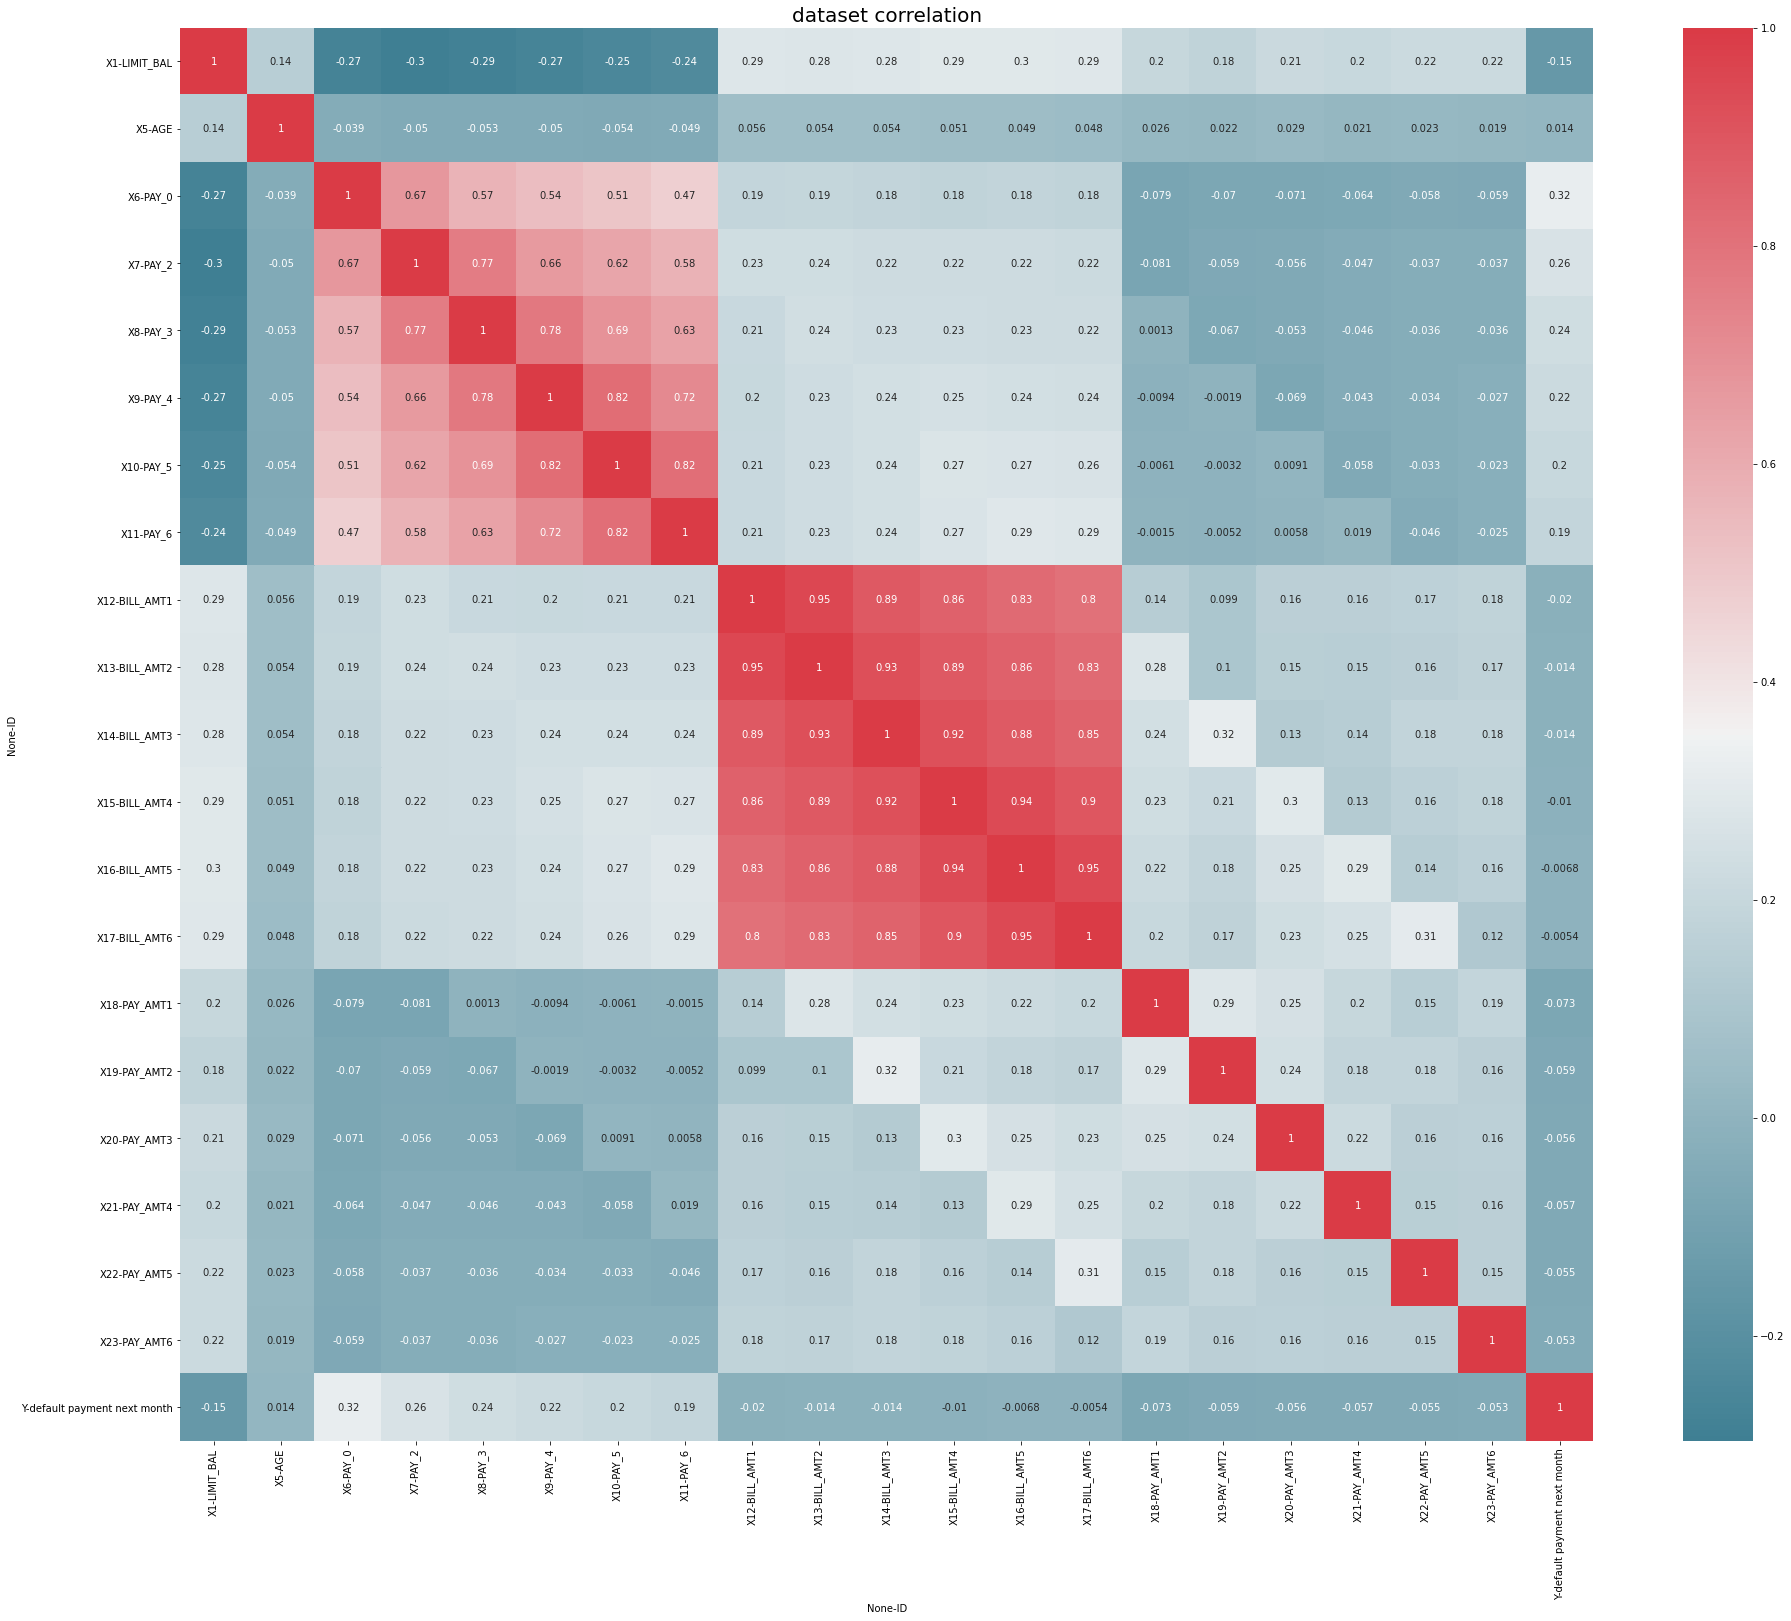

In [25]:
# Display correlation 
f, ax = plt.subplots(figsize=(32, 26))
corr = df.corr()
mp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot = True)
mp.set_title(label='dataset correlation', fontsize=20)

- BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, & BILL_AMT6 are highly correlated

Let's select our target value 

In [26]:
y = df['Y']
y

ID     default payment next month
1                               1
2                               1
3                               0
4                               0
5                               0
...                           ...
29996                           0
29997                           0
29998                           1
29999                           1
30000                           1

[30000 rows x 1 columns]

In [27]:
X = df.drop('Y', axis =1)

In [28]:
X = pd.get_dummies(data=X, columns=['X2', 'X3', 'X4'])
X.head()

(X1, LIMIT_BAL)  (X5, AGE)  (X6, PAY_0)  (X7, PAY_2)  (X8, PAY_3)  \
1          20000.0         24            2            2           -1   
2         120000.0         26           -1            2            0   
3          90000.0         34            0            0            0   
4          50000.0         37            0            0            0   
5          50000.0         57           -1            0           -1   

   (X9, PAY_4)  (X10, PAY_5)  (X11, PAY_6)  (X12, BILL_AMT1)  \
1           -1            -2            -2            3913.0   
2            0             0             2            2682.0   
3            0             0             0           29239.0   
4            0             0             0           46990.0   
5            0             0             0            8617.0   

   (X13, BILL_AMT2)  (X14, BILL_AMT3)  (X15, BILL_AMT4)  (X16, BILL_AMT5)  \
1            3102.0             689.0               0.0               0.0   
2            1725.0            2682.0            3272.0            3455.0   
3           14027.0           13559.0           14331.0           14948.0   
4           48233.0           49291.0           28314.0           28959.0   
5            5670.0           35835.0           20940.0           19146.0   

   (X17, BILL_AMT6)  (X18, PAY_AMT1)  (X19, PAY_AMT2)  (X20, PAY_AMT3)  \
1               0.0              0.0            689.0              0.0   
2            3261.0              0.0           1000.0           1000.0   
3           15549.0           1518.0           1500.0           1000.0   
4           29547.0           2000.0           2019.0           1200.0   
5           19131.0           2000.0          36681.0          10000.0   

   (X21, PAY_AMT4)  (X22, PAY_AMT5)  (X23, PAY_AMT6)  ('X2', 'SEX')_female  \
1              0.0              0.0              0.0                     1   
2           1000.0              0.0           2000.0                     1   
3           1000.0           1000.0           5000.0                     1   
4           1100.0           1069.0           1000.0                     1   
5           9000.0            689.0            679.0                     0   

   ('X2', 'SEX')_male  ('X3', 'EDUCATION')_graduate school  \
1                   0                                    0   
2                   0                                    0   
3                   0                                    0   
4                   0                                    0   
5                   1                                    0   

   ('X3', 'EDUCATION')_high school  ('X3', 'EDUCATION')_others  \
1                                0                           0   
2                                0                           0   
3                                0                           0   
4                                0                           0   
5                                0                           0   

   ('X3', 'EDUCATION')_university  ('X4', 'MARRIAGE')_married  \
1                               1                           1   
2                               1                           0   
3                               1                           0   
4                               1                           1   
5                               1                           1   

   ('X4', 'MARRIAGE')_others  ('X4', 'MARRIAGE')_single  
1                          0                          0  
2                          0                          1  
3                          0                          1  
4                          0                          0  
5                          0                          0

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   (X1, LIMIT_BAL)                      30000 non-null  float64
 1   (X5, AGE)                            30000 non-null  int64  
 2   (X6, PAY_0)                          30000 non-null  int64  
 3   (X7, PAY_2)                          30000 non-null  int64  
 4   (X8, PAY_3)                          30000 non-null  int64  
 5   (X9, PAY_4)                          30000 non-null  int64  
 6   (X10, PAY_5)                         30000 non-null  int64  
 7   (X11, PAY_6)                         30000 non-null  int64  
 8   (X12, BILL_AMT1)                     30000 non-null  float64
 9   (X13, BILL_AMT2)                     30000 non-null  float64
 10  (X14, BILL_AMT3)                     30000 non-null  float64
 11  (X15, BILL_AMT4)            

In [34]:
X = X.astype(np.float32)
y = y.astype(np.float32)

## 6. <a name="6">Train the classifier</a>
(<a href="#0">Go to top</a>)

Let's first train and test the classifier on the train and the test sets using different alogrithms.  

## Train

Next, specify the locations of the XGBoost algorithm containers.

Amazon SageMaker algorithms are packaged as Docker images. This gives you the flexibility to use almost any algorithm code with Amazon SageMaker, regardless of implementation language, dependent libraries, frameworks, and so on.

In [35]:
from sklearn.model_selection import train_test_split

# Get 80% of the data for training; the remaining 20% will be for validation and test
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.2)

# Split the remaining 20% of data as 10% test and 10% validation
test_features, val_features, test_labels, val_labels = train_test_split(test_features, test_labels, test_size=0.5)

print(f"Length of train_features is: {train_features.shape}")
print(f"Length of train_labels is: {train_labels.shape}")
print(f"Length of val_features is: {val_features.shape}")
print(f"Length of val_labels is: {val_labels.shape}")
print(f"Length of test_features is: {test_features.shape}")
print(f"Length of test_labels is: {test_labels.shape}")

Length of train_features is: (24000, 29)
Length of train_labels is: (24000, 1)
Length of val_features is: (3000, 29)
Length of val_labels is: (3000, 1)
Length of test_features is: (3000, 29)
Length of test_labels is: (3000, 1)


In [ ]:
# Feature scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [36]:
import sagemaker

# Call the LinearLearner estimator object
binary_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier')

In [37]:
train_records = binary_estimator.record_set(train_features, train_labels, channel='train')
val_records = binary_estimator.record_set(val_features, val_labels, channel='validation')
test_records = binary_estimator.record_set(test_features, test_labels, channel='test')

ValueError: Labels must be a Vector

In [ ]:
binary_estimator.fit([train_records, val_records, test_records])

In [ ]:
sagemaker.analytics.TrainingJobAnalytics(binary_estimator._current_job_name, 
                                         metric_names = ['test:binary_classification_accuracy', 
                                                         'test:precision', 
                                                         'test:recall']
                                        ).dataframe()